In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)
library(BiocParallel)
setwd('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
mylox1 <- readRDS('h5ad/R/milo_MNP_1.5.RDS')
mylox2 <- readRDS('h5ad/R/milo_MNP_2.5.RDS')

In [3]:
da.res_1.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_1.5vsuntreated_MNP.RDS')
da.res_2.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_2.5vsuntreated_MNP.RDS')

In [4]:
da.res_1.5 <- annotateNhoods(mylox1, da.res_1.5, coldata_col = "fine_clustering")
da.res_1.5$fine_clustering <- ifelse(da.res_1.5$fine_clustering_fraction < 0.7, "Mixed", da.res_1.5$fine_clustering)
da.res_2.5 <- annotateNhoods(mylox2, da.res_2.5, coldata_col = "fine_clustering")
da.res_2.5$fine_clustering <- ifelse(da.res_2.5$fine_clustering_fraction < 0.7, "Mixed", da.res_2.5$fine_clustering)

In [5]:
library(ggbeeswarm)
library(ggplot2)
new_DA_beeswarm_split <- function (da.res1, da.res2, max = 5, group.by = NULL, split.by =NULL, alpha = 0.1, subset.nhoods = NULL, size = 2, filter = c('Mixed', 'doublets')) 
{
    da.res1$split = split.by[1]
    da.res2$split = split.by[2]
    da.res <- rbind(da.res1, da.res2)
    da.res$beta[da.res$beta > max] <- max
    da.res$beta[da.res$beta < -max] <- -max
    da.res <- da.res %>% filter(!get(group.by) %in% filter)
    if (!is.null(group.by)) {
        if (!group.by %in% colnames(da.res)) {
            stop(paste0(group.by, " is not a column in da.res. Have you forgot to run annotateNhoods(x, da.res, ", 
                group.by, ")?"))
        }
        if (is.numeric(da.res[, group.by])) {
            stop(paste0(group.by, " is a numeric variable. Please bin to use for grouping."))
        }
        da.res <- mutate(da.res, group_by = da.res[, group.by])
    }
    else {
        da.res <- mutate(da.res, group_by = "g1")
    }    
    if (!is.factor(da.res[, "group_by"])) {
        message(paste0("Converting group.by to factor..."))
        da.res <- mutate(da.res, factor(group_by, levels = unique(group_by)))
    }
    if (!is.null(subset.nhoods)) {
        da.res <- da.res[subset.nhoods, ]
    }
        
    da.res <- da.res %>% mutate(is_signif = ifelse(SpatialFDR < alpha, 
        1, 0)) %>% mutate(beta_color = ifelse(is_signif == 1, 
        beta, NA)) %>% arrange(group_by) %>% mutate(Nhood = factor(Nhood, 
        levels = unique(Nhood)))
    p <- ggplot(da.res, aes(group_by, beta, color = beta_color)) + 
        scale_color_gradient2(midpoint = 0, low = "#0571b0", mid = '#f7f7f7', high = "#ca0020", limits=c(-max/3, max/3), oob=scales::squish) +
        guides(color = "none") + 
        xlab(group.by) + 
        ylab("beta") + 
        geom_quasirandom(alpha = 1, size = size) +
        coord_flip() + 
        theme_bw() + 
        theme(axis.title.y = element_blank(),
              axis.title.x = element_text(size=20, color = '#000000'),
              axis.text = element_text(size=20, color = '#000000'),
              axis.ticks = element_line(color = '#000000'),
              panel.border = element_rect(colour = "#000000")
            ) + 
        facet_wrap(split~.) +
        theme(strip.background = element_blank(), strip.text.x = element_text(angle = 0, size = 20, color = '#000000'))
    p$data <- p$data[order(p$data$beta_color, na.last = FALSE), ]
    return(p)
}

Converting group.by to factor...



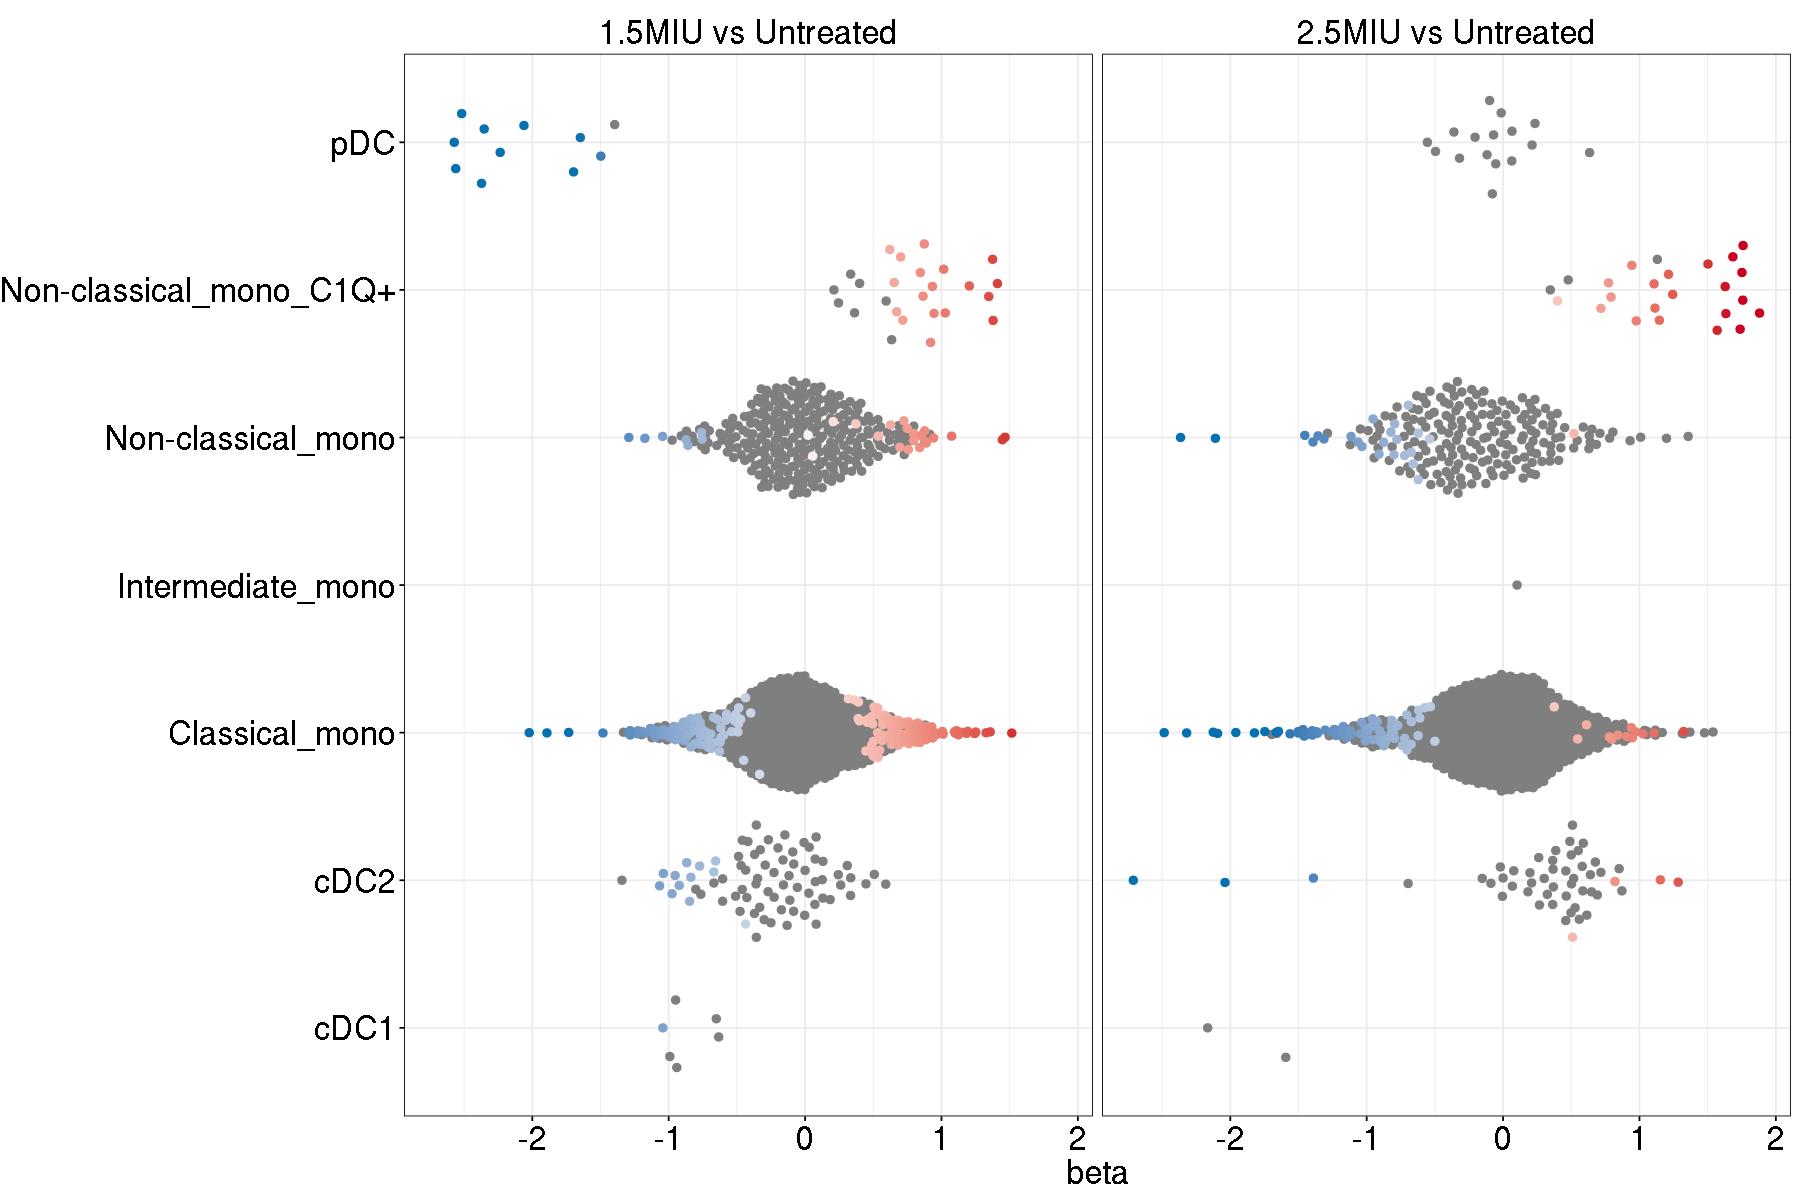

In [6]:
options(repr.plot.width=15, repr.plot.height=10)
p <- new_DA_beeswarm_split(da.res_1.5, da.res_2.5, group.by = "fine_clustering", split.by = c('1.5MIU vs Untreated', '2.5MIU vs Untreated'), size = 2)
p

In [7]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
cbind.fill <- function(...){
    nm <- list(...) 
    nm <- lapply(nm, as.matrix)
    n <- max(sapply(nm, nrow)) 
    do.call(cbind, lapply(nm, function (x) 
        rbind(x, matrix(, n-nrow(x), ncol(x))))) 
}

In [10]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Classical_mono' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Classical_mono' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.6440381,-0.8040047
-0.5968266,-0.5745201
0.8889622,-0.8252367
-0.8922857,0.5469297
0.5323106,-0.9581763
-0.6174887,-1.3989021
0.3176145,-1.5617239
-0.6452854,-1.2239438
0.9487821,-0.7043826


In [11]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Non-classical_mono' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Non-classical_mono' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.69495407,-0.6946800
-0.87213924,-0.6735020
0.62742758,-0.7787917
1.44637378,-0.7217305
0.75728730,-1.0345849
-0.85840068,-0.8748401
0.02204782,-1.4536217
0.74849437,-0.8227072
0.87701401,-0.9095488


In [12]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Non-classical_mono_C1Q+' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Non-classical_mono_C1Q+' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
1.0164257,0.3994509
1.3785836,0.7916517
0.6534396,1.1137466
1.4105079,1.6338218
0.7165325,0.7173366
0.6213094,1.7382076
1.2042552,1.5025864
0.8649458,1.1461706
1.3467059,1.1070508


In [13]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Intermediate_mono' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Intermediate_mono' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,NA


In [14]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'pDC' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'pDC' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-1.647706,NA
-2.352705,NA
-2.061212,NA
-1.697517,NA
-2.572241,NA
-2.517688,NA
-2.235438,NA
-2.561493,NA
-1.497660,NA


In [15]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'cDC1' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'cDC1' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-1.042599,NA


In [16]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'cDC2' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'cDC2' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.9754810,1.2839541
-0.9225461,1.1531566
-0.4364111,-2.7109633
-0.6556303,-1.3902331
-1.0664780,0.5091890
-0.7731222,0.8208525
-0.8466928,-2.0388316
-0.9527394,NA
-1.0389707,NA
